In [1]:
%load_ext autoreload
%autoreload 2

import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import numpy as np
import pandas as pd
import scipy.stats

In [2]:
import diffxpy.api as de

# Introduction

Differential expression analysis is a group of statistical tests that are used to establish whether there a exists a significant variation across a set of tested conditions for each gene. In its easiset form, this test can test for the difference between two distinct groups: This scenario can be handled with (Welch's) T-test, rank sum tests or Wald and likelihood ratio tests (LRT). Wald tests and LRT allow for more adaptive assumptions on the noise model and can therefore be more statistically correct. Moreover, they also allow the testing of more complex effect, e.g. for the variation across many groups (a single p-value for: Is there any difference between four conditions?) or across continuous covariates (a single covariate for: Is a gene expression trajectory in time non-constant?). Below, we introduce these and similar scenarios. We dedicated separate tutorials to a selection of scenarios that require a longer introduction.

# Testing a single coefficient

The test of a single coefficient is the easiest differential expression test one can imagine, the comparison of two groups is a sub-scenario of this case.

## Standard test

### Generate data:

Here, we use a simulator provided by batchglm and pack the simulated data into an AnnData object. One can also directly supply arrays to diffxpy.

In [3]:
from batchglm.api.models.tf1.glm_nb import Simulator

sim = Simulator(num_observations=200, num_features=100)
sim.generate_sample_description(num_batches=0, num_conditions=2)
sim.generate_params(
    rand_fn_loc=lambda shape: np.random.uniform(-0.1, 0.1, shape),
    rand_fn_scale=lambda shape: np.random.uniform(0.1, 2, shape)
)
sim.generate_data()

data = anndata.AnnData(
    X=sim.x,
    var=pd.DataFrame(index=["gene" + str(i) for i in range(sim.x.shape[1])]),
    obs=sim.sample_description
)

Transforming to str index.


### Run differential expression test

We first tackle this scenario with a Wald test.


The wald test checks if a certain coefficient introduces a significant difference in the expression of a gene.

It needs a formula which describes the setup of the model and the factor of the formula `factor_loc_totest` which should be tested.

Usually, this factor divides the samples into two groups, e.g. `condition 0` and `condition 1`.
In this case, diffxpy will automatically choose the coefficient to test.
If there are more than two groups specified by the factor, the coefficient which should be tested has to be set manually by specifying `coef_totest`. This coefficient should refer to one of the groups specified by `factor_loc_totest`, e.g. `condition 1`.


In [4]:
test = de.test.wald(
    data=data,
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition"
)

I1101 08:29:16.389711 4648003008 estimator.py:51] training strategy:
{'max_steps': 1000, 'update_b_freq': 5}


### Obtain the results

The p-/q-values can be obtained by calling test.pval / test.qval:

In [5]:
test.pval[:10]

array([0.60139521, 0.22027086, 0.57619872, 0.93807501, 0.65553144,
       0.88983104, 0.49675858, 0.08771343, 0.07318849, 0.22164236])

In [6]:
test.qval[:10]

array([0.84703551, 0.53478002, 0.84703551, 0.99868475, 0.86406426,
       0.98870116, 0.82114705, 0.31758301, 0.31758301, 0.53478002])

test.summary() returns a pandas DataFrame with a quick overview of the test results:

In [7]:
test.summary().iloc[:10,:]

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,gene0,0.601395,0.847036,-0.060085,435.015015,False,0.007131,-0.060085,0.115018,-1405.466779
1,gene1,0.220271,0.534780,0.116396,514.085022,False,0.019504,0.116396,0.094955,-1421.041301
2,gene2,0.576199,0.847036,-0.043876,602.700012,False,0.046234,-0.043876,0.078498,-1430.723576
3,gene3,0.938075,0.998685,0.004080,446.040009,False,0.044234,0.004080,0.052521,-1288.610775
4,gene4,0.655531,0.864064,0.019108,504.510010,False,0.062664,0.019108,0.042835,-1295.435961
5,gene5,0.889831,0.988701,-0.008318,483.299988,False,0.037404,-0.008318,0.060049,-1342.506068
6,gene6,0.496759,0.821147,-0.052436,480.125000,False,0.029464,-0.052436,0.077157,-1371.953554
7,gene7,0.087713,0.317583,-0.109675,492.584991,False,0.007987,-0.109675,0.064228,-1350.015749
8,gene8,0.073188,0.317583,-0.125621,533.655029,False,0.006187,-0.125621,0.070114,-1380.828275
9,gene9,0.221642,0.534780,-0.099408,493.225006,False,0.002494,-0.099408,0.081337,-1389.021227


- `gene`: gene name / identifier
- `pval`: p-value of the gene
- `qval`: multiple testing - corrected p-value of the gene
- `log2fc`: log_2 fold change between `no coefficient` and `coefficient`
- `grad`: the gradient of the gene's log-likelihood
- `coef_mle` the maximum-likelihood estimate of the coefficient in liker-space
- `coef_sd` the standard deviation of the coefficient in liker-space
- `ll`: the log-likelihood of the estimation

`test.plot_volcano()` creates a volcano plot of p-values vs. fold-change:

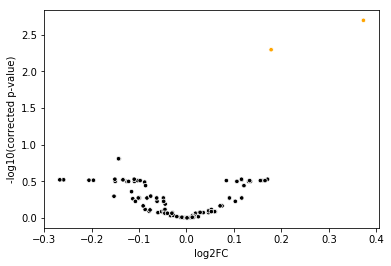

In [8]:
test.plot_volcano(corrected_pval=True, min_fc=1.05, alpha=0.05, size=20)

`plot_vs_ttest()` shows the correlation between t-test p-values and the wald test p-values

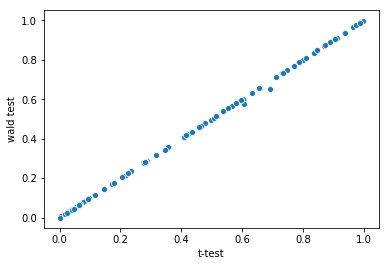

In [9]:
test.plot_vs_ttest()

## Vary the test

Diffxpy supports Welch's t-tests, rank sum tests, Wald tests (as above) and likelihood ratio tests.

### Welch's t-test

For t-tests and rank sum tests, the `grouping` argument indicates the the name of the column in sample description or adata.obs which contains two groups, ie. entries which come from a unique set of length two.

In [10]:
test_tt = de.test.t_test(
    data=data,
    grouping="condition"
)

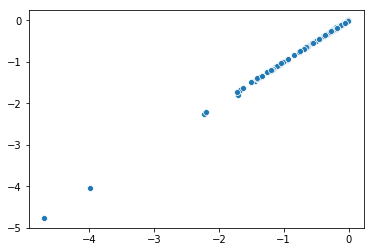

In [11]:
sns.scatterplot(
    x=test.log10_pval_clean(),
    y=test_tt.log10_pval_clean()
)

### Rank sum test

In [12]:
test_rank = de.test.rank_test(
    data=data,
    grouping="condition"
)

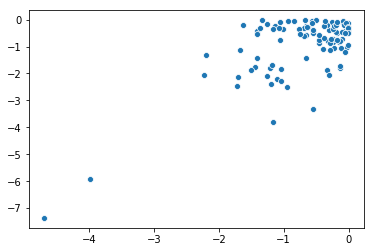

In [13]:
sns.scatterplot(
    x=test.log10_pval_clean(),
    y=test_rank.log10_pval_clean()
)

### Likelihood ratio test

In a likelihood ratio test (LRT), one specifies a null (reduced) and an alternative (full) model. The difference set of coefficients of both models is tested. The LRT requires 2 models to be fit rather than one in the Wald test and therefore tends to be slightly slower.

In [36]:
#test_lrt = de.test.lrt(
#    data=data, 
#    full_formula_loc="1+condition",
#    reduced_formula_loc="1"
#)

In [37]:
#sns.scatterplot(
#    x=test.log10_pval_clean(),
#    y=test_lrt.log10_pval_clean()
#)

### Two-sample wrapper

For the special case of two group comparisons, one can also easily toggle between tests using the `two_sample wrapper`.

In [15]:
test_2s = de.test.two_sample(
    data=data, 
    grouping="condition",
    test="t_test"
)

This yields exactly the same as calling t-test twice:

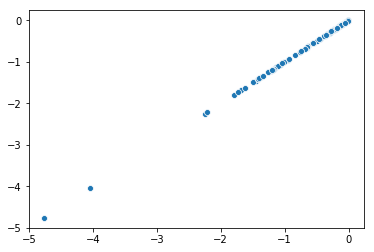

In [16]:
sns.scatterplot(
    x=test_tt.log10_pval_clean(),
    y=test_2s.log10_pval_clean()
)

## Inclusion of size factors

One can also use pre-computed size factors in diffxpy by supplying them to the test function.

In [17]:
size_factors = np.random.uniform(0.5, 1.5, (sim.x.shape[0]))

In [18]:
test_sf = de.test.wald(
    data=data,
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition",
    size_factors=size_factors
)

I1101 08:29:55.117454 4648003008 estimator.py:51] training strategy:
{'max_steps': 1000, 'update_b_freq': 5}


And results can be retrieved as beford. Note that the results differ now as we imposed size factors without changing the data:

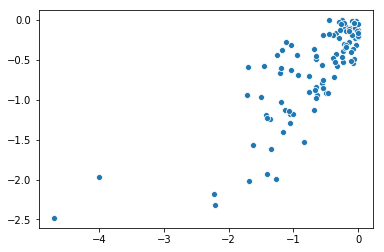

In [19]:
sns.scatterplot(
    x=test.log10_pval_clean(),
    y=test_sf.log10_pval_clean()
)

## Inclusion of continuous effects

One can also regress out size factors. Alternatively one can account for other continuous effects such as time, space or concentration. 

We also provide a separate tutorial for continuous covariate modelling in the notebook "modelling_continuous_covariates". Please consider this section here a short introduction and refer to the dedicated tutorial for further information.

### Numeric covariates

Firstly, you have to indicate that you are supplying a continuous effect if you want to do so. We will otherwise turn it into a catgeorical effect and this will not produce the desired results. We do this so that we can make sure that there are no errors arising from numeric and catgeorical columns in pandas DataFrames. Here, we add the size factor into the anndata object to make it accessible to the model:

In [20]:
data.obs["size_factors"] = size_factors

In [21]:
test_regressed_sf = de.test.wald(
    data=data,
    formula_loc="~ 1 + condition + size_factors",
    factor_loc_totest="condition",
    as_numeric=["size_factors"]
)

I1101 08:29:58.174185 4648003008 estimator.py:51] training strategy:
{'max_steps': 1000, 'update_b_freq': 5}


Again, this gives different results to using size factors to scale to model only:

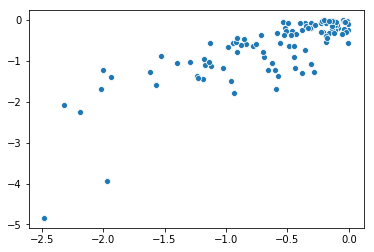

In [22]:
sns.scatterplot(
    x=test_sf.log10_pval_clean(),
    y=test_regressed_sf.log10_pval_clean()
)

### Spline basis transformation

It may be desirable to not fit a linear trend to a continuous covariate but to allow smooth trends in this covariate, such as smooth trends of total counts, time, space or concentration. This can be solved by using a spline basis space representation of the continuous covariate. Diffxpy does this automatically in a separate wrapper `continuous_1d()`:

In [23]:
test_spline_sf = de.test.continuous_1d(
    data=data,
    formula_loc="~ 1 + condition + size_factors",
    formula_scale="~ 1",
    factor_loc_totest="condition",
    continuous="size_factors",
    df=4,
    quick_scale=False
)

I1101 08:30:00.283493 4648003008 estimator.py:51] training strategy:
{'max_steps': 1000, 'update_b_freq': 5}


The spline model has more degrees of freedom (df=4 means 4 degrees of freedom) to fit the expression trend of each gene as a function of the size facotr than the simple linear model (1 degree of freedom) had. Accordingly, the p-values change again:

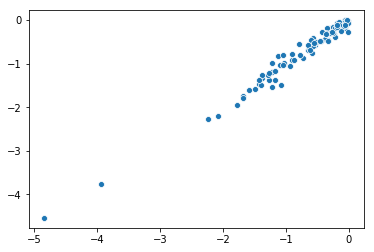

In [24]:
sns.scatterplot(
    x=test_regressed_sf.log10_pval_clean(),
    y=test_spline_sf.log10_pval_clean()
)

# Testing a multiple coefficients with a Wald test

We know turn to tests that cannot be performed with T-tests or rank sum tests because they involve more than two groups (or more general: multiple coefficients).

## Generate data:

We now simulate not only two conditions but four conditions, which results in 3 coefficients to be tested: Note that the first group is absorbed into the intercept as is standard in generalized linear models.

In [26]:
from batchglm.api.models.tf1.glm_nb import Simulator

sim = Simulator(num_observations=200, num_features=100)
sim.generate_sample_description(num_batches=0, num_conditions=4)
sim.generate_params(
    rand_fn_loc=lambda shape: np.random.uniform(-0.1, 0.1, shape),
    rand_fn_scale=lambda shape: np.random.uniform(0.1, 2, shape)
)
sim.generate_data()

data = anndata.AnnData(
    X=sim.x,
    var=pd.DataFrame(index=["gene" + str(i) for i in range(sim.x.shape[1])]),
    obs=sim.sample_description
)

Transforming to str index.


## Run differential expression test

We can now choose whether we want to collectively test all coefficients of the condition factor or whether we test the significance of a selected set of coefficients.

### Test a whole factor

In [27]:
test_fac = de.test.wald(
    data=data,
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition"
)

I1101 08:30:21.557281 4648003008 estimator.py:51] training strategy:
{'max_steps': 1000, 'update_b_freq': 5}


Again, we can look at results like before:

In [28]:
test_fac.summary().iloc[:10, :]

,gene,pval,qval,log2fc,mean,zero_mean,grad,ll
0,gene0,0.277851,0.492273,0.147647,421.869995,False,0.027561,-1312.509915
1,gene1,0.491807,0.656583,0.047191,520.349976,False,0.030544,-1280.711568
2,gene2,0.359895,0.580475,-0.087734,484.940002,False,0.043177,-1334.831021
3,gene3,0.450769,0.645822,-0.149193,467.864990,False,0.035538,-1371.121205
4,gene4,0.898119,0.935540,-0.057238,536.635010,False,0.053513,-1358.993988
5,gene5,0.399238,0.604905,-0.168357,438.980011,False,0.004615,-1362.527003
6,gene6,0.185840,0.379265,-0.194161,539.265015,False,0.074427,-1384.323391
7,gene7,0.640233,0.768172,0.123167,473.200012,False,0.069339,-1369.790906
8,gene8,0.044763,0.223817,-0.131154,504.015015,False,0.045032,-1370.312173
9,gene9,0.048412,0.230011,-0.276199,508.024994,False,0.066663,-1368.800212


### Test selected coefficients

In this artificial example, we test all coefficients necessary to test the entire factor. First, we preview the coefficient names and then yield the desired list to diffxpy.

In [29]:
de.utils.preview_coef_names(
    sample_description=data.obs,
    formula="~ 1 + condition"
)

['Intercept', 'condition[T.1]', 'condition[T.2]', 'condition[T.3]']

In [30]:
test_coef = de.test.wald(
    data=data,
    formula_loc="~ 1 + condition",
    coef_to_test=['condition[T.1]', 'condition[T.2]', 'condition[T.3]']
)

I1101 08:30:23.589154 4648003008 estimator.py:51] training strategy:
{'max_steps': 1000, 'update_b_freq': 5}


Finally, we perform a sanity check that the factor and coefficient test yielded the same p-values:

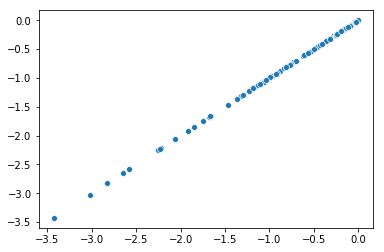

In [31]:
sns.scatterplot(
    x=test_fac.log10_pval_clean(),
    y=test_coef.log10_pval_clean()
)

# Running a test across multiple partitions of a data set

In some scenarios, one wants to perform a test in multiple partitions of a data set. This can be testing the condition effect separately at each observed time point or in each cell type cluster for example.

WATCH OUT: The use of expression-derived cell type cluster information is confounded with the tested expression.

Similar to what we describe here, one can also run a Welch's t-test, a rank sum test or a likelihood-ratio test on partitions of a data set.

## Generate data:

We now simulate conditions across cell types.

In [32]:
from batchglm.api.models.tf1.glm_nb import Simulator

sim = Simulator(num_observations=200, num_features=100)
sim.generate_sample_description(num_batches=0, num_conditions=4)
sim.generate_params(
    rand_fn_loc=lambda shape: np.random.uniform(-0.1, 0.1, shape),
    rand_fn_scale=lambda shape: np.random.uniform(0.1, 2, shape)
)
sim.generate_data()
sample_description = sim.sample_description
sample_description["cell_type"] = np.repeat(
    np.array(["c1", "c2", "c3", "c4"]), 
    int(sim.input_data.num_observations / 4)
)

data_part = anndata.AnnData(
    X=sim.x,
    var=pd.DataFrame(index=["gene" + str(i) for i in range(sim.x.shape[1])]),
    obs=sample_description
)

Transforming to str index.


## Run differential expression test

We can now partition the data set by cell type and conduct a test across conditions in each cell type.

In [33]:
part = de.test.partition(
    data=data_part,
    parts="cell_type"
)
test_part = part.wald(
    formula_loc="~ 1 + condition",
    factor_loc_totest="condition"
)

I1101 08:30:25.862147 4648003008 estimator.py:51] training strategy:
{'max_steps': 1000, 'update_b_freq': 5}
I1101 08:30:27.281496 4648003008 estimator.py:51] training strategy:
{'max_steps': 1000, 'update_b_freq': 5}
I1101 08:30:28.577277 4648003008 estimator.py:51] training strategy:
{'max_steps': 1000, 'update_b_freq': 5}
I1101 08:30:30.068945 4648003008 estimator.py:51] training strategy:
{'max_steps': 1000, 'update_b_freq': 5}


Note that there is one test and p-value for each partition for each gene now. We can summarize test statistics across partitions using summary:

In [34]:
test_part.summary().iloc[:10, :]

,gene,pval,qval,log2fc,mean
0,gene0,0.007775,0.207674,0.821535,499.535004
1,gene1,0.000003,0.000260,1.617482,447.505005
2,gene2,0.326601,0.859476,0.342792,476.575012
3,gene3,0.227182,0.646721,0.359799,543.405029
4,gene4,0.569666,0.837744,0.239041,448.140015
5,gene5,0.041472,0.425347,0.768011,553.570007
6,gene6,0.044566,0.368951,0.522767,520.119995
7,gene7,0.023625,0.207674,0.464294,485.609985
8,gene8,0.000009,0.000889,0.268387,521.169983
9,gene9,0.056168,0.468501,0.525614,451.494995


Or look the results of a single partition:

In [35]:
test_part.tests[test_part.partitions.index("c1")].summary().iloc[:10, :]

,gene,pval,qval,log2fc,mean,zero_mean,grad,ll
0,gene0,0.236630,0.850233,0.378361,474.540009,False,0.149255,-349.672424
1,gene1,0.388072,0.887907,0.372109,432.959991,False,0.028610,-342.420953
2,gene2,0.915428,0.998093,-0.132995,459.140015,False,0.021319,-336.802719
3,gene3,0.331338,0.887907,-0.129664,575.559998,False,0.051677,-326.841868
4,gene4,0.649671,0.997315,0.165691,429.859985,False,0.022056,-322.434363
5,gene5,0.146981,0.746963,0.481870,543.159973,False,0.008542,-354.784068
6,gene6,0.085076,0.654431,0.362354,502.820007,False,0.020550,-327.777691
7,gene7,0.527121,0.896196,0.321824,478.440002,False,0.036779,-345.983630
8,gene8,0.001942,0.097125,-0.835358,485.220001,False,0.065138,-343.036688
9,gene9,0.056168,0.561681,0.364328,391.779999,False,0.016551,-311.557848


# Further reading

Was your scenario not captured by any of these classes of tests? diffxpy wraps a number of further advanced tests to which we dedicated separate tutorials. These are:
    
- pairwise tests between groups ("multiple_tests_per_gene")
- grouwise tests versus all other groups ("multiple_tests_per_gene")
- modelling continuous covariates such as as total counts, time, pseudotime, space, concentration ("modelling_continuous_covariates")
- modelling equality constraints, relevant for scenarios with perfect confounding ("modelling_constraints")

Still not covered? Post an issue on the [diffxpy](https://github.com/theislab/diffxpy) GitHub repository!